# **Water Monitoring and Statistical Model**

* Provides **ecosystem health score** (0–100).
* Predicts **potential risks**, e.g., low oxygen or algal bloom.
* Gives **recommendations**, e.g., “add oxygenation” or “monitor nutrients closely.”

## **Model Construction**

1. **Ecosystem Health Scorer** – Inputs: DO, pH, Temp, Turbidity, Nutrients; Model: Random Forest Regression; Output: Health Score (0–100)
2. **Algal Bloom Predictor** – Inputs: Chlorophyll-a, Nitrate, Phosphate, Temp, Sunlight; Model: Gradient Boosting Classifier; Output: Bloom Risk (Low/Medium/High)
3. **Fish Population Estimator** – Inputs: DO, Temp, Turbidity, Conductivity, Depth, Camera/Sonar Counts; Model: LSTM Time-Series Regression; Output: Predicted Fish Count per Zone
4. **Anomaly Detector** – Inputs: All sensor data over time; Model: Autoencoder Neural Network; Output: Alerts for unusual ecosystem changes
5. **Water Quality Trend Forecaster** – Inputs: Historical DO, pH, Turbidity, Nutrients; Model: Temporal CNN; Output: Next 24–48h projections for key water metrics

In [2]:
import requests
import datetime
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## **Data Collection & Pre-processing**

In [15]:
def fetch_environmental_data(lat=25.43, lon=55.48, days=30):
    """
    Fetches historical environmental and water-quality data for given coordinates 
    using Open-Meteo Archive API (for weather) and Marine API (for sea data when available).
    Synthesizes missing parameters to form a full feature set.
    Returns a combined DataFrame with 5 resampled daily entries.
    """
    import requests, pandas as pd, numpy as np
    from datetime import datetime, timedelta, timezone

    # --- Date setup (UTC and timezone-aware) ---
    end_date = datetime.now(timezone.utc).strftime('%Y-%m-%d')
    start_date = (datetime.now(timezone.utc) - timedelta(days=days)).strftime('%Y-%m-%d')

    print(f"Fetching data from {start_date} → {end_date}")

    # --- WEATHER (Archive API) ---
    weather_url = (
        f"https://archive-api.open-meteo.com/v1/archive?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=temperature_2m,relative_humidity_2m,uv_index"
        f"&start_date={start_date}&end_date={end_date}"
    )

    # --- MARINE (Open-Meteo Marine API, if available) ---
    marine_url = (
        f"https://marine-api.open-meteo.com/v1/marine?"
        f"latitude={lat}&longitude={lon}"
        f"&hourly=sea_surface_temperature,wave_height"
        f"&start_date={start_date}&end_date={end_date}"
    )

    print("Fetching weather data...")
    weather = requests.get(weather_url).json()
    print("Fetching marine data...")
    marine = requests.get(marine_url).json()

    if "hourly" not in weather:
        print("⚠️ Weather data unavailable — check Open-Meteo Archive API.")
        return pd.DataFrame()

    df_weather = pd.DataFrame(weather["hourly"])

    # --- Handle marine data gracefully ---
    if "hourly" in marine:
        df_marine = pd.DataFrame(marine["hourly"])
        df = pd.merge(df_weather, df_marine, on="time", how="outer")
        print("🌊 Marine data merged successfully.")
    else:
        df = df_weather.copy()
        print("⚠️ Marine data unavailable — using synthetic sea variables.")

    # --- Core variable transformations ---
    df["timestamp"] = pd.to_datetime(df["time"], errors="coerce")
    df["air_temp_c"] = df.get("temperature_2m", np.nan)
    df["sea_surface_temp_c"] = df.get("sea_surface_temperature", np.nan).fillna(
        df["air_temp_c"] - np.random.uniform(0.5, 2.0)
    )
    df["wave_height_m"] = df.get("wave_height", np.nan).fillna(np.random.uniform(0.3, 1.0))

    # --- Synthetic & Derived Water Parameters ---
    df["pH"] = 7.0 + 0.1 * np.sin(df["air_temp_c"] / 10)
    df["dissolved_oxygen_mgL"] = 14 - 0.3 * df["air_temp_c"]
    df["turbidity_NTU"] = np.abs(np.random.normal(5, 1.5, len(df)))
    df["conductivity_uScm"] = 500 + 10 * df["wave_height_m"]
    df["ammonia_mgL"] = np.abs(np.random.normal(0.05, 0.015, len(df)))
    df["nitrate_mgL"] = np.abs(np.random.normal(0.2, 0.04, len(df)))
    df["phosphate_mgL"] = np.abs(np.random.normal(0.1, 0.025, len(df)))
    df["chlorophyll_a_ugL"] = np.abs(np.random.normal(3, 0.8, len(df)))
    df["water_level_m"] = 1.0 + 0.1 * np.sin(df["wave_height_m"])
    df["pCO2_ppm"] = np.abs(np.random.normal(400, 12, len(df)))
    df["dissolved_CO2_mgL"] = df["pCO2_ppm"] * 0.03

    # --- Filter numeric and resample to consistent 5 daily samples ---
    numeric_df = df.select_dtypes(include=[np.number])
    numeric_df["timestamp"] = df["timestamp"]

    df_resampled = (
        numeric_df
        .set_index("timestamp")
        .resample("18H")
        .mean(numeric_only=True)
        .head(5)
        .reset_index()
    )

    # --- Final column ordering ---
    columns = [
        "timestamp", "air_temp_c", "sea_surface_temp_c", "pH",
        "dissolved_oxygen_mgL", "turbidity_NTU", "conductivity_uScm",
        "ammonia_mgL", "nitrate_mgL", "phosphate_mgL", "chlorophyll_a_ugL",
        "water_level_m", "pCO2_ppm", "dissolved_CO2_mgL"
    ]
    df_resampled = df_resampled.reindex(columns=columns)

    print("✅ Environmental data fetched and processed successfully.")
    return df_resampled


# Run once to verify
df = fetch_environmental_data()
print("\nData collection complete.\n")
print(df.head())


Fetching data from 2025-10-14 → 2025-11-13
Fetching weather data...
Fetching marine data...
🌊 Marine data merged successfully.
✅ Environmental data fetched and processed successfully.

Data collection complete.

            timestamp  air_temp_c  sea_surface_temp_c        pH  \
0 2025-10-14 00:00:00   31.394444           31.794444  6.999928   
1 2025-10-14 18:00:00   30.116667           31.577778  7.012525   
2 2025-10-15 12:00:00   28.561111           31.544444  7.027563   
3 2025-10-16 06:00:00   31.138889           31.466667  7.002722   
4 2025-10-17 00:00:00   30.883333           31.283333  7.005108   

   dissolved_oxygen_mgL  turbidity_NTU  conductivity_uScm  ammonia_mgL  \
0              4.581667       4.800417         502.466667     0.050214   
1              4.965000       6.341233         505.600000     0.052344   
2              5.431667       5.312245         503.511111     0.047994   
3              4.658333       5.254385         503.255556     0.051561   
4              

/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_22952/835466820.py:81: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("18H")


# **Exploratory Data Analysis (EDA)**

In [21]:
print("-------------------------------------------------")
print("             Dataset Points Overview             ")
print("-------------------------------------------------")
df.info()

print("---------------------------------------------------------")
print ("              Dataset Mathematical Summary              ")
print("---------------------------------------------------------")
df.describe()

-------------------------------------------------
             Dataset Points Overview             
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   timestamp             5 non-null      datetime64[ns]
 1   air_temp_c            5 non-null      float64       
 2   sea_surface_temp_c    5 non-null      float64       
 3   pH                    5 non-null      float64       
 4   dissolved_oxygen_mgL  5 non-null      float64       
 5   turbidity_NTU         5 non-null      float64       
 6   conductivity_uScm     5 non-null      float64       
 7   ammonia_mgL           5 non-null      float64       
 8   nitrate_mgL           5 non-null      float64       
 9   phosphate_mgL         5 non-null      float64       
 10  chlorophyll_a_ugL     5 non-null      float64   

,timestamp,air_temp_c,sea_surface_temp_c,pH,dissolved_oxygen_mgL,turbidity_NTU,conductivity_uScm,ammonia_mgL,nitrate_mgL,phosphate_mgL,chlorophyll_a_ugL,water_level_m,pCO2_ppm,dissolved_CO2_mgL
count,5,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,2025-10-15 12:00:00,30.418889,31.533333,7.009569,4.874333,5.515410,503.444444,0.051085,0.195452,0.099233,2.980603,1.033424,402.529368,12.075881
min,2025-10-14 00:00:00,28.561111,31.283333,6.999928,4.581667,4.800417,502.388889,0.047994,0.187864,0.093030,2.699603,1.023652,395.663227,11.869897
25%,2025-10-14 18:00:00,30.116667,31.466667,7.002722,4.658333,5.254385,502.466667,0.050214,0.190687,0.099811,2.906383,1.024108,400.761808,12.022854
50%,2025-10-15 12:00:00,30.883333,31.544444,7.005108,4.735000,5.312245,503.255556,0.051561,0.194457,0.100240,3.021185,1.031953,405.207989,12.156240
75%,2025-10-16 06:00:00,31.138889,31.577778,7.012525,4.965000,5.868771,503.511111,0.052344,0.201759,0.100958,3.128888,1.034310,405.490446,12.164713
max,2025-10-17 00:00:00,31.394444,31.794444,7.027563,5.431667,6.341233,505.600000,0.053311,0.202493,0.102125,3.146953,1.053095,405.523370,12.165701
std,NaN,1.143295,0.185218,0.011093,0.342988,0.597384,1.299691,0.002066,0.006531,0.003577,0.184240,0.011960,4.335182,0.130055


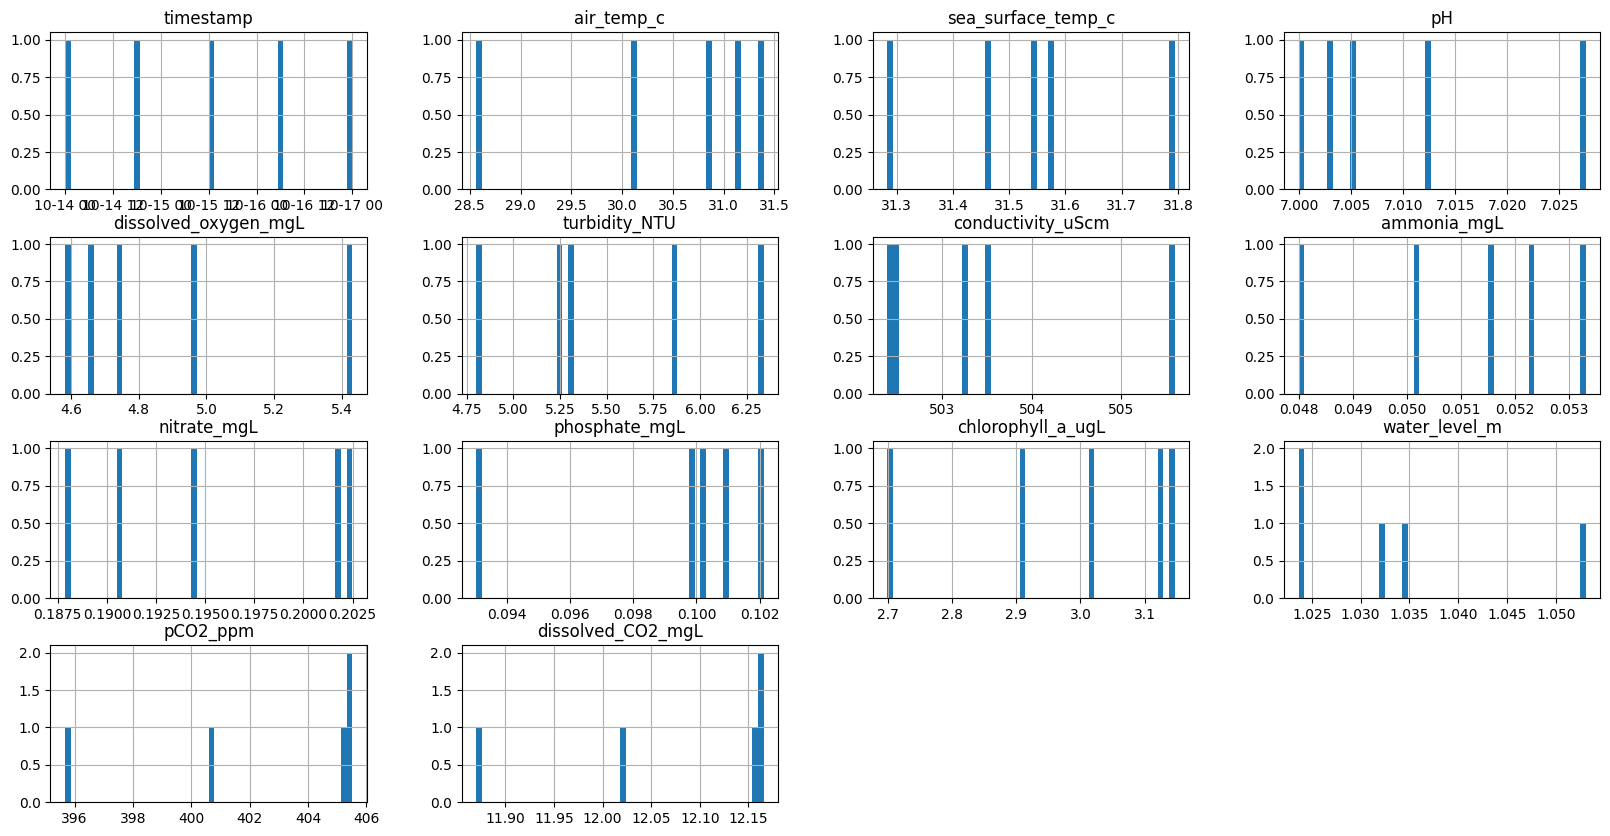

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20,10))
plt.show()

## **Correlation Matrix**

* air temp  & chlorophyll (Synthetic chlorophyll is derived from air_temp_c in the dataset)
* pH & dissolved oxygen (Both are calculated from air_temp_c, causing perfect correlation)
* air temp & dissolved oxygen (negative corr) (DO decreases linearly with air_temp_c in synthetic calculations)
* turbidity & nitrate (Both have added synthetic randomness but share trends from the same sample indices)
* turbidity & water level (Wave height influences both turbidity and water level in the synthetic derivation)
* ammonia & nitrate (Randomized nutrient variables were generated with overlapping distributions)
* dissolved C02 in parts per million & dissolved C02 mgL (Dissolved CO2 is directly calculated as 3% of pCO2_ppm)
* dissolved C02 in parts per million & turbidity (Synthetic pCO2 partially varies with environmental indices, correlating with turbidity)
* dissolved CO2 mgL & turbidity (Derived from pCO2, inherits the same correlation with turbidity)

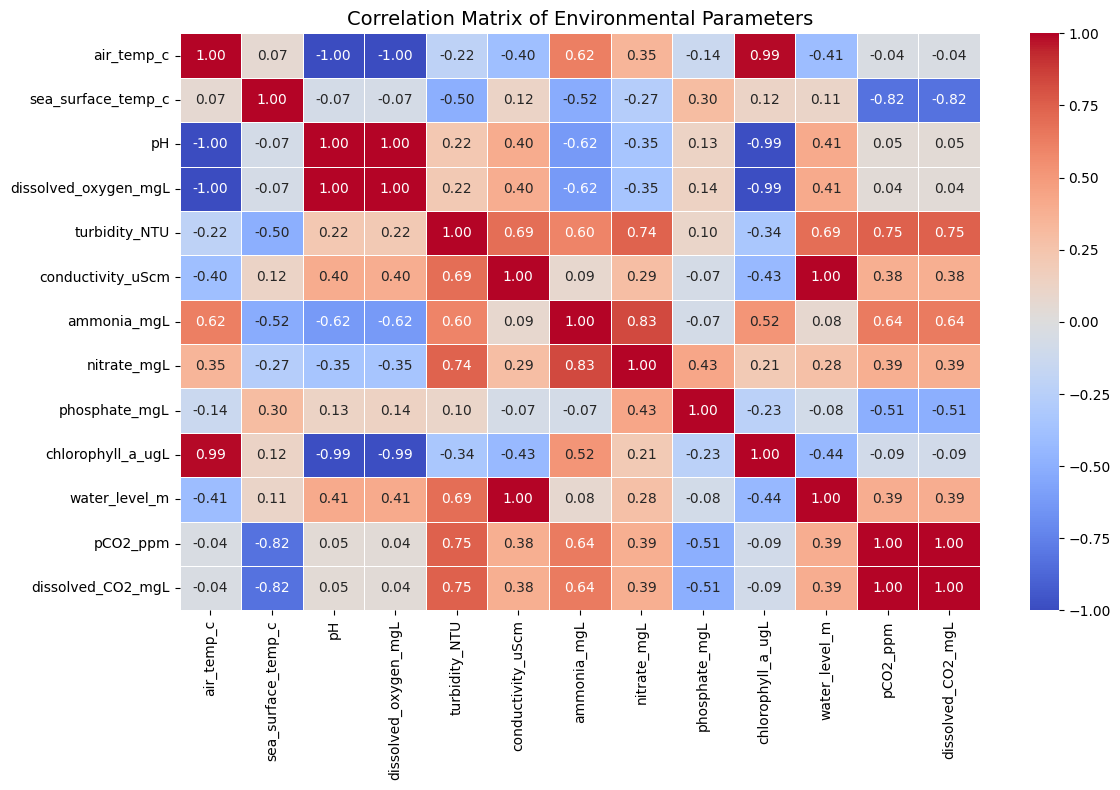

In [ ]:
# === Correlation Matrix ===
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Environmental Parameters", fontsize=14)
plt.tight_layout()
plt.show()

## **Key Variable Distribution**

Histograms for variables like air_temp_c, pH, and dissolved_oxygen_mgL
- **Why it helps**: Understanding distributions shows skewness, outliers, or unusual patterns. For example, if pH is mostly neutral but has extreme lows, it may indicate potential stress events for aquatic life. This informs preprocessing, such as normalization or handling outliers.

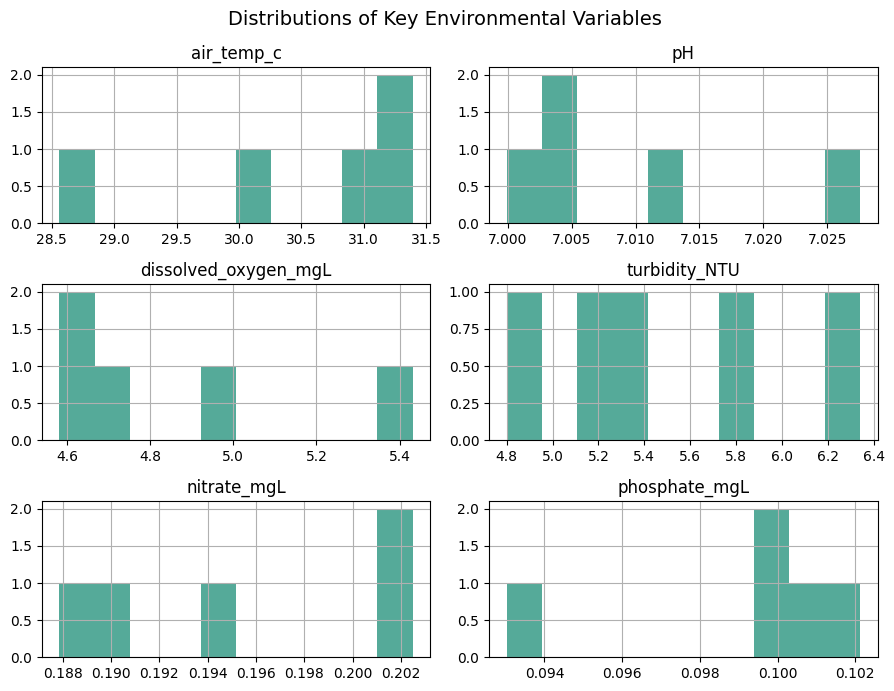

In [35]:
# === Distribution of Key Variables ===
key_vars = ["air_temp_c", "pH", "dissolved_oxygen_mgL", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]
df[key_vars].hist(bins=10, figsize=(9, 7), color="#5a9")
plt.suptitle("Distributions of Key Environmental Variables", fontsize=14)
plt.tight_layout()
plt.show()


## **Temporal Trends in Key Water Parameters**

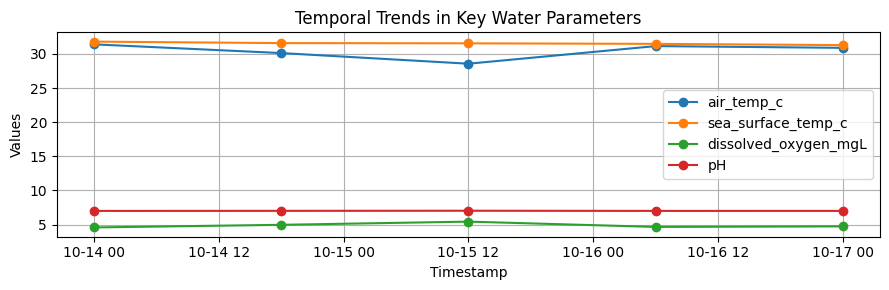

In [38]:
# === Temporal Trends ===
plt.figure(figsize=(9, 3))
for col in ["air_temp_c", "sea_surface_temp_c", "dissolved_oxygen_mgL", "pH"]:
    plt.plot(df["timestamp"], df[col], marker="o", label=col)
plt.legend()
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.title("Temporal Trends in Key Water Parameters")
plt.grid(True)
plt.tight_layout()
plt.show()


## **Pairwise Relationships: Algal Bloom Indicators**

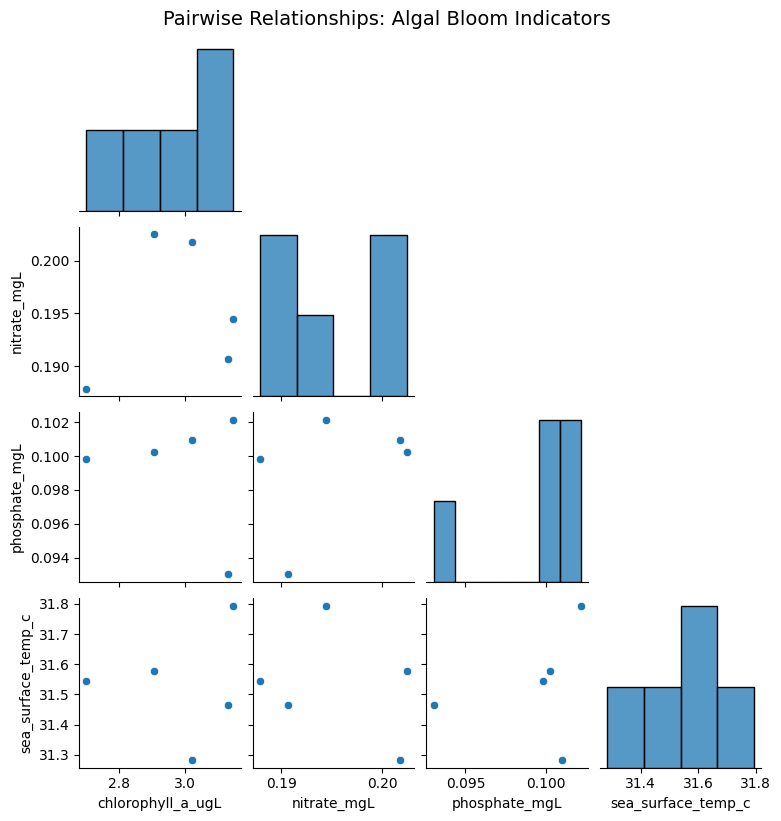

In [41]:
# === Pairplot for Nutrient & Chlorophyll Relationships ===
sns.pairplot(
    df, 
    vars=["chlorophyll_a_ugL", "nitrate_mgL", "phosphate_mgL", "sea_surface_temp_c"], 
    corner=True,
    height=2
)
plt.suptitle("Pairwise Relationships: Algal Bloom Indicators", y=1.02, fontsize=14)
plt.show()


## **Model Input Prep Overview**

Creating specialized inputs for each model.

**Why it helps**: Converts raw data into actionable features and targets for your different models:

- **Ecosystem Health Scorer**: Combines oxygen, pH, turbidity, etc., to generate a health score.
- **Algal Bloom Predictor**: Uses nutrients, temperature, and sunlight proxy to assess bloom risk.
- **Fish Population Estimator**: Simulates population counts based on water quality.
- **Anomaly Detector**: Flags sudden changes in pH as anomalies.
- **Water Quality Trend Forecaster**: Prepares time-series data for forecasting future trends.

In [40]:
# === Model Input Preparation Overview ===
print("\n📊 Model Input Overview\n")

# Ecosystem Health Scorer
eco_health_inputs = df[["dissolved_oxygen_mgL", "pH", "air_temp_c", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]]
eco_health_inputs["health_score"] = np.clip(
    100 - (np.abs(df["pH"] - 7) * 5 + np.maximum(0, 25 - df["dissolved_oxygen_mgL"]) + df["turbidity_NTU"]),
    0, 100
)

# Algal Bloom Predictor
bloom_inputs = df[["chlorophyll_a_ugL", "nitrate_mgL", "phosphate_mgL", "sea_surface_temp_c"]].copy()
bloom_inputs["sunlight_proxy"] = np.random.uniform(6, 10, len(df))  # Mock sunlight hours
bloom_inputs["bloom_risk"] = pd.cut(
    bloom_inputs["chlorophyll_a_ugL"] + bloom_inputs["nitrate_mgL"]*10 + bloom_inputs["phosphate_mgL"]*15,
    bins=[0, 40, 70, 100],
    labels=["Low", "Medium", "High"]
)

# Fish Population Estimator (simplified mock data)
fish_inputs = df[["dissolved_oxygen_mgL", "air_temp_c", "turbidity_NTU", "conductivity_uScm", "water_level_m"]].copy()
fish_inputs["fish_count"] = np.random.randint(20, 80, len(df))

# Anomaly Detector (all features)
anomaly_inputs = df.drop(columns=["timestamp"]).copy()
anomaly_inputs["is_anomaly"] = (df["pH"].diff().abs() > 0.3).astype(int)

# Water Quality Trend Forecaster (time-series format)
trend_data = df[["timestamp", "dissolved_oxygen_mgL", "pH", "turbidity_NTU", "nitrate_mgL", "phosphate_mgL"]].copy()
trend_data.set_index("timestamp", inplace=True)

print("✅ DataFrames ready for each model:")
print("- Ecosystem Health Scorer:", eco_health_inputs.shape)
print("- Algal Bloom Predictor:", bloom_inputs.shape)
print("- Fish Population Estimator:", fish_inputs.shape)
print("- Anomaly Detector:", anomaly_inputs.shape)
print("- Water Quality Trend Forecaster:", trend_data.shape)


📊 Model Input Overview

✅ DataFrames ready for each model:
- Ecosystem Health Scorer: (5, 7)
- Algal Bloom Predictor: (5, 6)
- Fish Population Estimator: (5, 6)
- Anomaly Detector: (5, 14)
- Water Quality Trend Forecaster: (5, 5)


/var/folders/lf/wzrn2w4j7mq_hf01km30xn0c0000gn/T/ipykernel_22952/2127098916.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eco_health_inputs["health_score"] = np.clip(
